<img src="img/TJI_logo_whitebg_440x220.jpg" alt="drawing" style="width: 220px;float: right"/>

# Analysis: Exploration of civilians-shot data
---

## Overview

Summary statistics of civilians shot by police, from Peace Officer Involved Shooting Reports submitted to the Texas Attorney General.

## Summary of findings
* Data collection began in September 2015
* About 160 civilians are shot each year by police.
* About 50% die from the incident.
* About 37% are white, 33% hispanic, 27% black.
* About 95% are male.
* About 85% are carrying deadly weapons (60% of which are firearms).
* About 60% are between 20 and 40 years of age.
* Sat and Sun have fewer shootings per day than Mon-Fri.
* About 80% of the time, multiple officers are involved -- though usually only details for one officer are recorded.
* 50% of shootings happen in the 5 largest counties: Harris (Houston), Bexar (Houston), Dallas (Dallas), Tarrant (Fort Worth), and Travis (Austin).


## Datasets used:
* `tji/officer-involved-shootings/shot_civilians.csv`
* `tji/auxiliary-datasets/texas_counties`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)

## [ Setup and load data ]

In [1]:
import datetime as dt

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline

%load_ext watermark
%watermark -a 'Everett Wetchler' -g -d -t -z -w -p numpy,pandas,matplotlib,seaborn,datadotworld

Everett Wetchler 2018-05-31 20:06:45 PDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
seaborn 0.7.1
datadotworld 1.6.0
Git hash: c304f867152cb4001ae28bb830598e281928ba1e
watermark 1.5.0


Removing 2 past plots


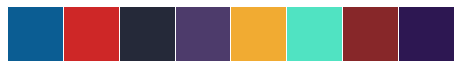

In [2]:
from lib.utils import *
from lib.style import *
from wordcloud import WordCloud

plotsaver = PlotSaver('../plots/', 'ois_civilians_', numbering=False)
sns.palplot(sns.color_palette())

In [3]:
datasets = dw.load_dataset('tji/officer-involved-shootings', force_update=True)
shootings = datasets.dataframes['shot_civilians']

first_shooting = shootings.date_incident.min().strftime('%Y-%m-%d')
last_shooting = shootings.date_incident.max().strftime('%Y-%m-%d')
print("Civilians shot data from %s to %s" % (first_shooting, last_shooting))

shootings.head()

Civilians shot data from 2015-09-02 to 2018-05-14


,date_incident,incident_address,incident_city,incident_county,incident_zip,incident_longitude,incident_latitude,incident_census_tract,incident_result_of,incident_call_other,civilian_name_first,civilian_name_last,civilian_name_full,civilian_gender,civilian_age,civilian_race,civilian_died,officer_age_1,officer_race_1,officer_gender_1,agency_name_1,agency_report_date_1,agency_city_1,agency_county_1,agency_zip_1,agency_name_person_filling_out_1,agency_email_person_filling_out_1,officer_age_2,officer_race_2,officer_gender_2,officer_caused_injury_2,agency_name_2,agency_report_date_2,agency_city_2,agency_county_2,agency_zip_2,agency_name_person_filling_out_2,agency_email_person_filling_out_2,officer_age_3,officer_race_3,officer_gender_3,officer_caused_injury_3,agency_name_3,agency_report_date_3,agency_city_3,agency_county_3,agency_zip_3,agency_name_person_filling_out_3,agency_email_person_filling_out_3,officer_age_4,...,agency_name_person_filling_out_7,agency_email_person_filling_out_7,officer_age_8,officer_race_8,officer_gender_8,agency_name_8,agency_report_date_8,agency_city_8,agency_county_8,agency_zip_8,agency_name_person_filling_out_8,agency_email_person_filling_out_8,officer_age_9,officer_race_9,officer_gender_9,agency_name_9,agency_report_date_9,agency_city_9,agency_county_9,agency_zip_9,agency_name_person_filling_out_9,agency_email_person_filling_out_9,officer_age_10,officer_race_10,officer_gender_10,agency_name_10,agency_report_date_10,agency_city_10,agency_county_10,agency_zip_10,agency_name_person_filling_out_10,agency_email_person_filling_out_10,news_coverage_1,news_coverage_2,news_coverage_3,news_coverage_4,cdr_narrative,custodial_death_report,deadly_weapon,deadly_weapon_category,deadly_weapon_description,lea_narrative_published,lea_narrative_shorter,multiple_officers_involved,num_officers_recorded,num_reports_filed,num_rows_about_this_incident,officer_on_duty,time_incident,incident_location
0,2015-09-02,1010 MAGNOLIA STREET,FREEPORT,BRAZORIA,77541.0,-95.356262,28.944891,664400.0,TRAFFIC STOP,NARCOTIC STOP AND EVADING ARREST,RICKEY,MAYBERRY,RICKEY MAYBERRY,M,30.0,BLACK,False,27.0,HISPANIC,M,FREEPORT POLICE DEPT,9/16/2015,FREEPORT,BRAZORIA,77541,PAMELA MORRIS,PMORRIS@FREEPORT.TX.US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,ABC 13,YOUR SOUTHEST TEXAS,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,True,1,1,1,True,NaN,POINT(-95.3562616 28.9448909)
1,2015-09-03,4840 E. PLANO PARKWAY,PLANO,COLLIN,75074.0,-96.642308,33.008128,32010.0,OTHER - SPECIFY TYPE OF CALL,ACCIDENTAL DISCHARGE RICOCHET DURING RANGE ACT...,NaN,NaN,NaN,M,55.0,WHITE,False,30.0,HISPANIC,M,PLANO POLICE DEPT,10/1/2015,PLANO,COLLIN,75074,CURTIS HOWARD,CURTISH@PLANO.GOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,(DETAILS MISSING),NaN,NaN,NaN,False,1,1,1,True,NaN,POINT(-96.6423077 33.0081284)
2,2015-09-04,101 COUCH CT.,SPRINGTOWN,PARKER,76082.0,-97.634194,32.916724,140409.0,OTHER - SPECIFY TYPE OF CALL,INVESTIGATION OF CRIMINAL ACTIVITY,SULLY JOE,LANIER,SULLY JOE LANIER,M,36.0,WHITE,True,27.0,WHITE,M,PARKER CO SHERIFFS OFFICE,10/6/2015,WEATHERFORD,PARKER,76086,MEREDITH GRAY,MEREDITH.GRAY@PARKERCOUNTYTX.COM,56.0,WHITE,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,WFAA,DFW CBS LOCAL,STAR TELEGRAM,FOX 4 NEWS,DECEDENT SHOT A RIFLE AT LE OFFICERS WHOM RETU...,True,True,FIREARM,FIREARM,NaN,FIRED AT OFFICERS,True,2,1,1,True,NaN,POINT(-97.6341935 32.9167242)
3,2015-09-05,4926 CHENNAULT ROAD,HOUSTON,HARRIS,77033.0,-95.344966,29.

## [ WHEN do shootings happen? ]

In [4]:
shootings['year'] = shootings['date_incident'].apply(lambda dt: '%d' % (dt.year))
shootings['month'] = shootings['date_incident'].apply(lambda dt: '%d-%02d' % (dt.year, dt.month))

In [5]:
shootings.groupby(['year', 'civilian_died']).size().unstack()[::-1]

civilian_died,False,True
year,,
2018,19,44
2017,80,81
2016,93,83
2015,40,26


Saving plot to ../plots/ois_civilians_year.png


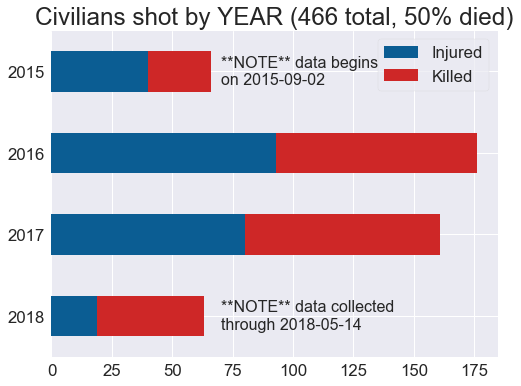

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

numbers = '(%d total, %.0f%% died)' % (
    len(shootings), shootings['civilian_died'].mean() * 100)

ax.set_title('Civilians shot by YEAR %s' % numbers)

df = shootings.groupby(['year', 'civilian_died']).size().unstack()[::-1]
df.columns = ['Injured', 'Killed']

df.plot(kind='barh', stacked=True, ax=ax, color=[TJI_BLUE, TJI_RED])
ax.set_ylabel('')
ax.text(70, 3, '**NOTE** data begins\non ' + first_shooting, verticalalignment='center', fontsize=16)
ax.text(70, 0, '**NOTE** data collected\nthrough ' + last_shooting, verticalalignment='center', fontsize=16)
ax.legend(title='')
plotsaver.saveplot(fig, 'year')

Saving plot to ../plots/ois_civilians_year_month.png


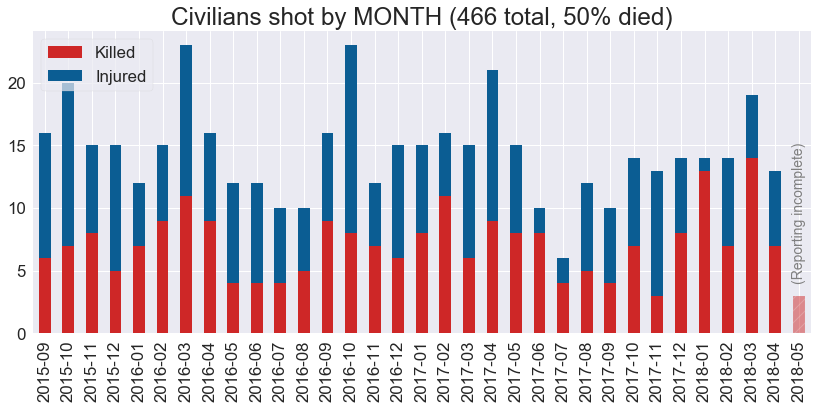

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.set_title('Civilians shot by MONTH %s' % numbers)

df = shootings.groupby(['month', 'civilian_died']).size().unstack()
df.columns = ['Injured', 'Killed']
df = df[['Killed', 'Injured']]
df.plot(kind='bar', stacked=True, ax=ax, color=[TJI_RED, TJI_BLUE])
alter_last_bar(ax)
ax.text(ax.get_xticks()[-1], 4, '(Reporting incomplete)', color='gray', rotation=90,
       horizontalalignment='center', verticalalignment='bottom')

ax.set_xlabel('')
ax.legend(title='', loc='upper left')
plt.subplots_adjust(left=.05, right=.95, bottom=0.2, top=0.9)
plotsaver.saveplot(fig, 'year_month', dpi=300)

In [8]:
s = df.sum(axis=1).iloc[:-1]
print('pearson r = %.2f, p = %.5f' % stats.pearsonr(list(range(len(s))), s.values))

pearson r = -0.21, p = 0.23836


Saving plot to ../plots/ois_civilians_weekday_hour.png


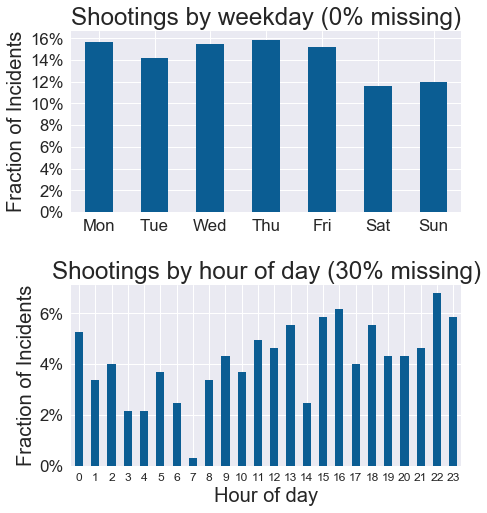

In [9]:
fig, axes = plt.subplots(2, 1)

ax = axes[0]
fig.set_size_inches(7, 8)
counts = shootings['date_incident'].apply(lambda dt: dt.weekday()).value_counts(True).sort_index()
ax.set_yticks(np.arange(0, 0.21, 0.02))
ax.set_ylabel('Fraction of Incidents')
percentify_y(ax, decimals=0)
counts.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
counts.plot(kind='bar', ax=ax)
ax.set_title('Shootings by weekday (%.0f%% missing)' % (shootings.date_incident.isnull().mean() * 100))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ax = axes[1]
shootings['hour'] = shootings.time_incident.dropna().apply(lambda t: int(t.split(':')[0])).astype(int)
shootings.hour.value_counts(True).sort_index().plot(kind='bar', ax=ax)
ax.set_xlabel('Hour of day')
ax.set_ylabel('Fraction of Incidents')
percentify_y(ax, decimals=0)
ax.set_title('Shootings by hour of day (%.0f%% missing)' % (shootings.time_incident.isnull().mean() * 100))
ax.set_xticklabels([int(t) for t in ax.get_xticks()], fontsize=12, rotation=0)


plt.subplots_adjust(hspace=.4)
plotsaver.saveplot(fig, 'weekday_hour')

## [ WHERE do shootings happen? ]

In [10]:
datasets = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
county_seats = datasets.dataframes['texas_counties'].set_index('county')['seat']
county_seats.head()

county
ANDERSON      PALESTINE
ANDREWS         ANDREWS
ANGELINA         LUFKIN
ARANSAS        ROCKPORT
ARCHER      ARCHER CITY
Name: seat, dtype: object

Saving plot to ../plots/ois_civilians_shootings_by_location.png


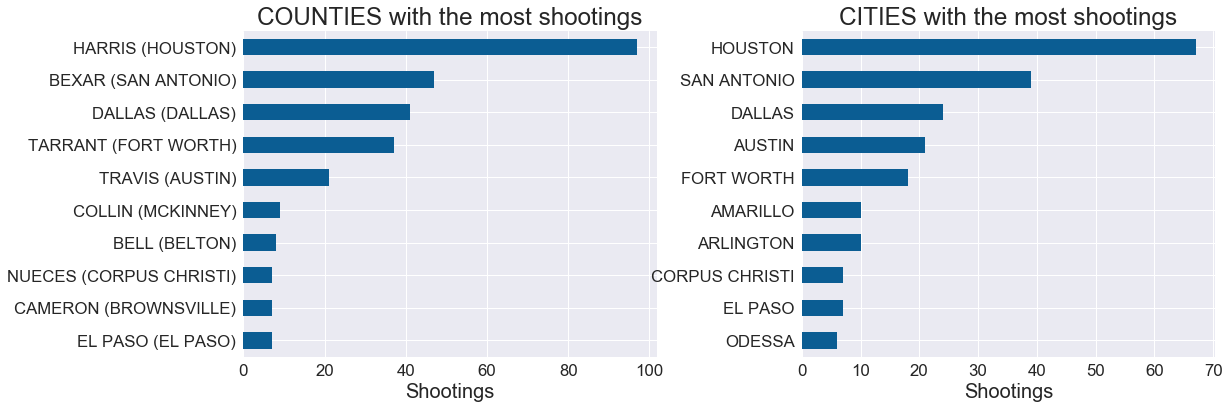

In [11]:
top_counties = shootings.incident_county.value_counts().head(10)
top_counties.index = pd.Series(top_counties.index).apply(
    lambda county: "%s (%s)" % (county, county_seats[county]))

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax = axes[0]
top_counties[::-1].plot(kind='barh', ax=ax)
ax.set_title('COUNTIES with the most shootings')
ax.set_xlabel("Shootings")

ax = axes[1]
shootings['incident_city'].value_counts()[:10][::-1].plot(kind='barh', ax=ax)
ax.set_title("CITIES with the most shootings")
ax.set_xlabel("Shootings")

plt.subplots_adjust(left=0.2, wspace=.35, right=.95)
plotsaver.saveplot(fig, 'shootings_by_location')

Saving plot to ../plots/ois_civilians_cumulative_shootings_by_county.png


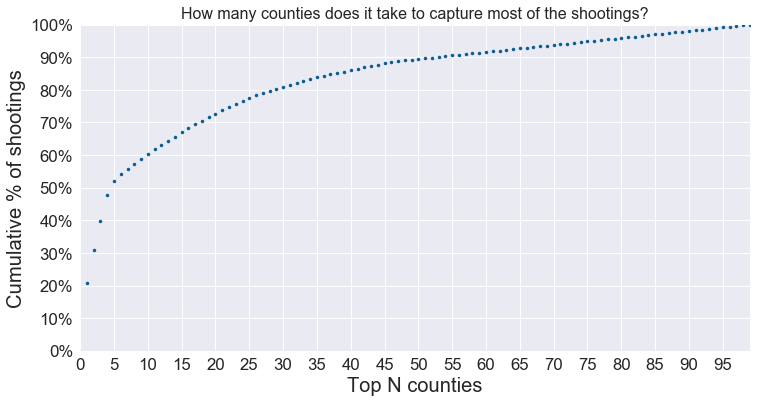

In [12]:
fig, ax = plt.subplots(1)
s = shootings['incident_county'].value_counts(True, ascending=False)
s.index = range(1, len(s) + 1)
s.cumsum().plot(ax=ax, marker='.', linewidth=0)
ax.set_ylim((0, 1))
ax.set_yticks(np.arange(0, 1.01, .1))
ax.set_yticklabels(['%d%%' % i for i in range(0, 101, 10)])
ax.set_xticks(range(0, 100, 5))
ax.legend_ = None
ax.set_title('How many counties does it take to capture most of the shootings?', fontsize=16)
ax.set_xlabel('Top N counties')
ax.set_ylabel('Cumulative % of shootings')
fig.set_size_inches(12, 6)
plotsaver.saveplot(fig, 'cumulative_shootings_by_county')

## [ What civilians get shot? ]

In [13]:
age_bucketed = shootings.civilian_age.dropna().apply(lambda age: int(age / 5) * 5)
age_bucketed.value_counts(True).sort_index()

5     0.002165
10    0.002165
15    0.069264
20    0.177489
25    0.145022
30    0.160173
35    0.140693
40    0.071429
45    0.077922
50    0.049784
55    0.047619
60    0.032468
65    0.012987
70    0.004329
75    0.002165
80    0.004329
Name: civilian_age, dtype: float64

Saving plot to ../plots/ois_civilians_civilian_summary.png


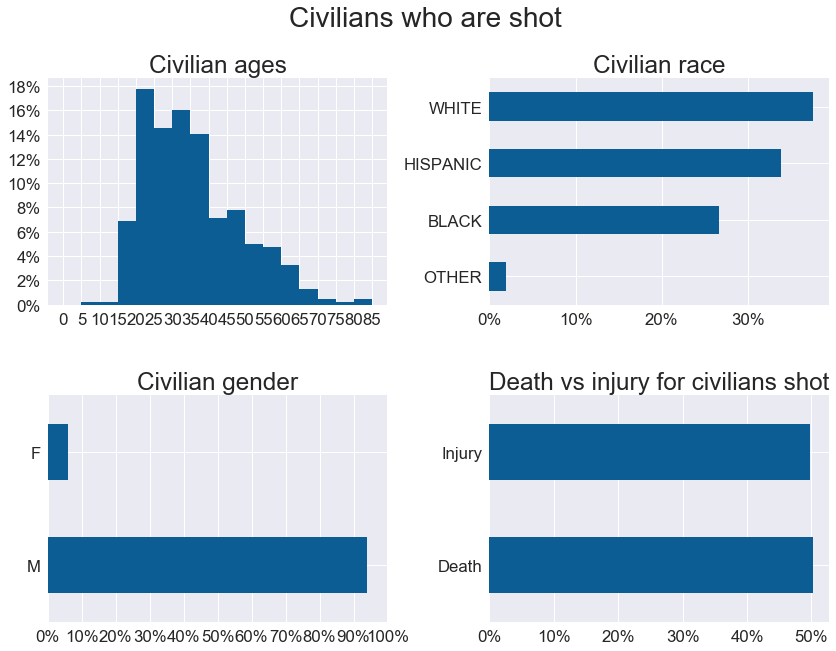

In [14]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 10)
fig.suptitle('Civilians who are shot', fontsize=28)

ax = axes[0][0]
# For some reason, the standard series.hist() method botches
# the y tick values, so we have to do this by hand
bins = np.arange(0, shootings.civilian_age.max() + 5, 5)
s = shootings.civilian_age.dropna()
s.hist(ax=ax, bins=bins)
ax.set_yticks(np.arange(0, ax.get_ylim()[1], len(s) / 50))
ax.set_yticklabels(['%.0f%%' % (y * 100 / len(s)) for y in ax.get_yticks()])
ax.set_xticks(bins)
ax.set_title('Civilian ages')

ax = axes[0][1]
shootings.civilian_race.value_counts(True)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Civilian race')
percentify_x(ax, decimals=0)

ax = axes[1][0]
shootings.civilian_gender.value_counts(True).plot(kind='barh', ax=ax)
ax.set_xticks(np.arange(0, 1.01, .1))
ax.set_title('Civilian gender')
percentify_x(ax)

ax = axes[1][1]
shootings['civilian_died'].value_counts(True).plot(kind='barh', ax=ax)
ax.set_yticklabels([ 'Death' if t.get_text() == 'True' else 'Injury' for t in ax.get_yticklabels()])
percentify_x(ax)
ax.set_title('Death vs injury for civilians shot')

plt.subplots_adjust(hspace=0.4, wspace=.3)
plotsaver.saveplot(fig, 'civilian_summary')

## What officers are involved?

Saving plot to ../plots/ois_civilians_officer_summary.png


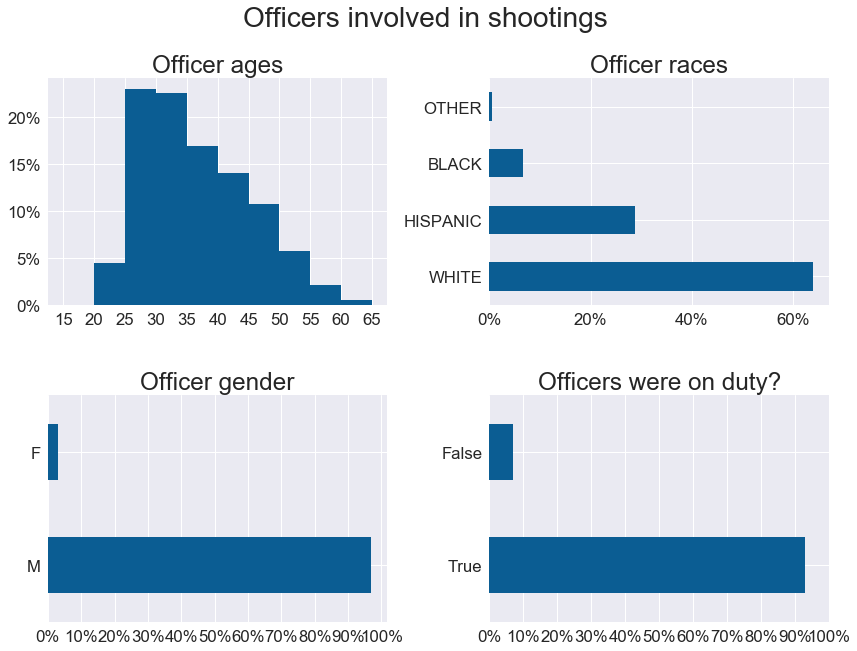

In [15]:
all_officer_ages = []
all_officer_races = []
all_officer_genders = []
for i in range(1, 11):
    all_officer_ages.extend(list(shootings['officer_age_%d' % i].dropna()))
    all_officer_races.extend(list(shootings['officer_race_%d' % i].dropna()))
    all_officer_genders.extend(list(shootings['officer_gender_%d' % i].dropna()))

all_officer_ages = pd.Series(all_officer_ages)
all_officer_races = pd.Series(all_officer_races)
all_officer_genders = pd.Series(all_officer_genders)
N_OFFICERS = shootings['num_officers_recorded'].sum()

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 10)
fig.suptitle('Officers involved in shootings', fontsize=28)

ax = axes[0][0]
# For some reason, the standard series.hist() method botches
# the y tick values, so we have to do this by hand
bins = np.arange(15, all_officer_ages.max() + 5, 5)
s = all_officer_ages.dropna()
s.hist(ax=ax, bins=bins)
ax.set_yticks(np.arange(0, ax.get_ylim()[1], len(s) / 20))
ax.set_yticklabels(['%.0f%%' % (y * 100 / len(s)) for y in ax.get_yticks()])
ax.set_xticks(bins)
ax.set_title('Officer ages')

ax = axes[0][1]
all_officer_races.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Officer races')
percentify_x(ax)

ax = axes[1][0]
all_officer_genders.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Officer gender')
ax.set_xticks(np.arange(0, 1.01, .1))
percentify_x(ax)

ax = axes[1][1]
shootings.officer_on_duty.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Officers were on duty?')
ax.set_xlim((0, 1))
ax.set_xticks(np.arange(0, 1.01, .1))
percentify_x(ax)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plotsaver.saveplot(fig, 'officer_summary')

## [ Miscellaneous ]

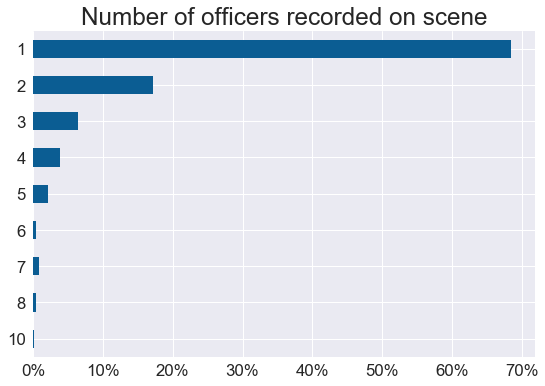

In [16]:
fig, ax = plt.subplots(1)
shootings.num_officers_recorded.value_counts(True).sort_index(ascending=False).plot(kind='barh', ax=ax)
ax.set_title('Number of officers recorded on scene')
ax.set_xticks(np.arange(0, 0.71, 0.1))
percentify_x(ax)

In [17]:
pd.crosstab(shootings['multiple_officers_involved'], shootings['num_officers_recorded'])

num_officers_recorded,1,2,3,4,5,6,7,8,10
multiple_officers_involved,,,,,,,,,
False,79,2,2,0,1,1,0,0,0
True,240,78,28,18,9,1,4,2,1


In [18]:
race_pairs = []
for i in range(1, 11):
    for civilian, officer in zip(shootings['civilian_race'], shootings['officer_race_%d' % i]):
        if pd.notnull(officer):
            race_pairs.append([civilian, officer])

tmp = pd.DataFrame(race_pairs, columns=['civilian', 'officer'])
tab = pd.crosstab(tmp['civilian'], tmp['officer'])
race_order = ['WHITE', 'BLACK', 'HISPANIC', 'OTHER']
tab.loc[race_order, race_order]

officer,WHITE,BLACK,HISPANIC,OTHER
civilian,,,,
WHITE,195,12,67,1
BLACK,154,26,43,2
HISPANIC,121,12,104,1
OTHER,14,1,4,0


Saving plot to ../plots/ois_civilians_incident_result_of.png


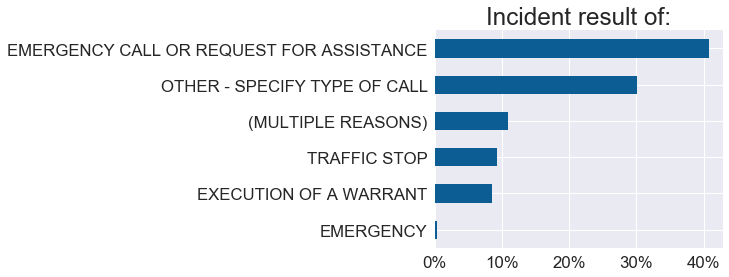

In [19]:
fig, ax = plt.subplots(1)
shootings.incident_result_of.apply(lambda res: '(MULTIPLE REASONS)' if ',' in res else res).value_counts(True)[::-1].plot(kind='barh', ax=ax)
fig.set_size_inches(10,4)
ax.set_title('Incident result of:')
percentify_x(ax, decimals=0)
plt.subplots_adjust(left=0.5)
plotsaver.saveplot(fig, 'incident_result_of')

Saving plot to ../plots/ois_civilians_cdr_exists.png


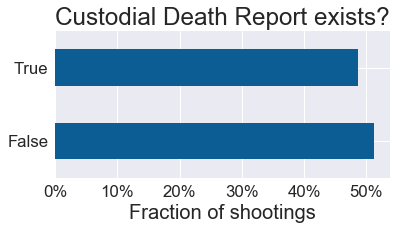

In [20]:
fig, ax = plt.subplots(1)
shootings.custodial_death_report.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Custodial Death Report exists?')
ax.set_xlabel('Fraction of shootings')
fig.set_size_inches(6, 3)
percentify_x(ax)
plt.subplots_adjust(bottom=0.2)
plotsaver.saveplot(fig, 'cdr_exists')

Saving plot to ../plots/ois_civilians_deadly_weapon.png


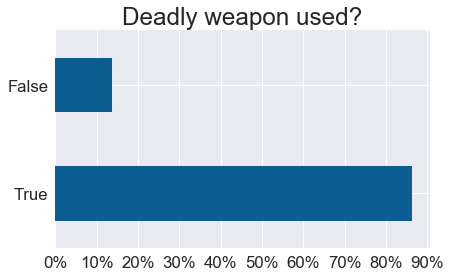

In [21]:
fig, ax = plt.subplots(1)
shootings.deadly_weapon.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Deadly weapon used?')
ax.set_xticks(np.arange(0, ax.get_xlim()[1], .1))
percentify_x(ax)
fig.set_size_inches(8, 4)
plt.subplots_adjust(left=0.25)
plotsaver.saveplot(fig, 'deadly_weapon')

Saving plot to ../plots/ois_civilians_deadly_weapon_types.png


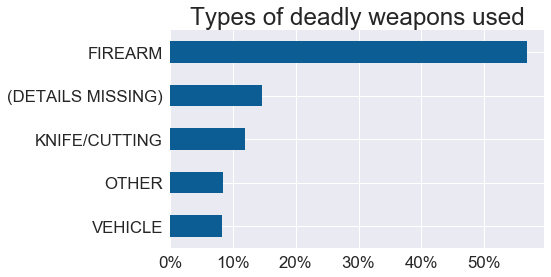

In [22]:
fig, ax = plt.subplots(1)
weapons = shootings.deadly_weapon_category[shootings.deadly_weapon_category != '(details missing)']
weapons.value_counts(True, ascending=True).plot(kind='barh', ax=ax)
ax.set_title('Types of deadly weapons used')
percentify_x(ax)
fig.set_size_inches(8, 4)
plt.subplots_adjust(left=0.25)
plotsaver.saveplot(fig, 'deadly_weapon_types')

227 CDR narratives published, 45 LEA narratives published
Saving plot to ../plots/ois_civilians_cdr_narrative_wordcloud.png


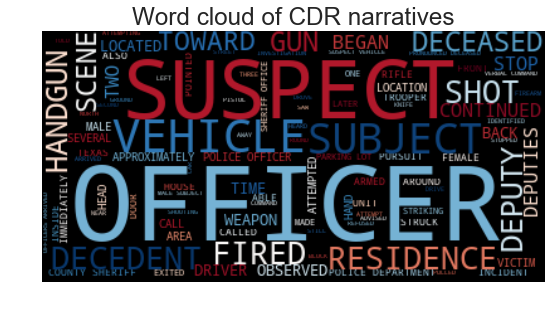

In [23]:
cdr = []
lea = []
for x in shootings['cdr_narrative'].values:
    if pd.notnull(x):
        cdr.append(x)
for x in shootings['lea_narrative_published'].values:
    if pd.notnull(x):
        lea.append(x)

print("%d CDR narratives published, %d LEA narratives published" % (len(cdr), len(lea)))

all_cdr = []
for x in cdr:
    all_cdr.extend(x.split())

remove_words = []#set(['suspect', 'officer', 'subject', 'police'])
text = []
for w in all_cdr:
    invalid = False
    for rem in remove_words:
        if rem in w.lower():
            invalid = True
            break
    if not invalid:
        text.append(w)
text = ' '.join(text)

cloud = WordCloud(background_color="black", max_words=100, colormap='RdBu').generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.gca().set_title('Word cloud of CDR narratives')
plotsaver.saveplot(plt.gcf(), 'cdr_narrative_wordcloud')